# Genotype-Phenotype Analysis for Stolerman Neurodevelopmental Syndrome (OMIM #618505)

In this notebook, we will conduct a genotype-phenotype analysis for [Stolerman Neurodevelopmental Syndrome](https://omim.org/entry/618505?search=618505), a rare developmental disorder caused by pathogenic variants in the *KDM6B* gene. This syndrome is characterized by motor and speech delay, mildly impaired intellectual development (in most patients), learning difficulties, and behavioral abnormalities, including autism spectrum disorder. Psychosis is observed in a small percentage of individuals over the age of 12 years. Most individuals have nonspecific and mild dysmorphic facial features without a common gestalt. A subset of patients may have involvement of other organ systems, including gastrointestinal with poor early feeding or gastroesophageal reflux, distal skeletal anomalies, and congenital heart defects. Most mutations occur de novo, but rare autosomal dominant inheritance with incomplete penetrance has been observed 

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2024-12-12
Using genophenocorr version 0.9.1


### KDM6B
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for KDM6B.

In [4]:
gene_symbol = 'KDM6B'
mane_tx_id = 'NM_001348716.2'
mane_protein_id = 'NP_001335645.1'

In [5]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.23') as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
len(phenopackets)

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Individuals Processed: 100%|██████████| 73/73 [00:00<00:00, 550.32individuals/s]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #12
    phenotype-features
     warnings:
     ·Maternal diabetes [HP:0009800] is not a descendant of Phenotypic abnormality [HP:0000118]
  patient #18
    phenotype-features
     warnings:
     ·Maternal diabetes [HP:0009800] is not a descendant of Phenotypic abnormality [HP:0000118]
  patient #67
    phenotype-features
     warnings:
     ·Maternal diabetes [HP:0009800] is not a descendant of Phenotypic abnormality [HP:0000118]


In [7]:
from gpsea.view import CohortViewer
viewer = CohortViewer(hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
61,Delayed speech and language development
57,Motor delay
39,Autistic behavior
32,Hypotonia
22,Feeding difficulties
20,Joint hypermobility
15,Macrocephaly
15,Sleep abnormality
13,"Intellectual disability, mild"
13,Attention deficit hyperactivity disorder


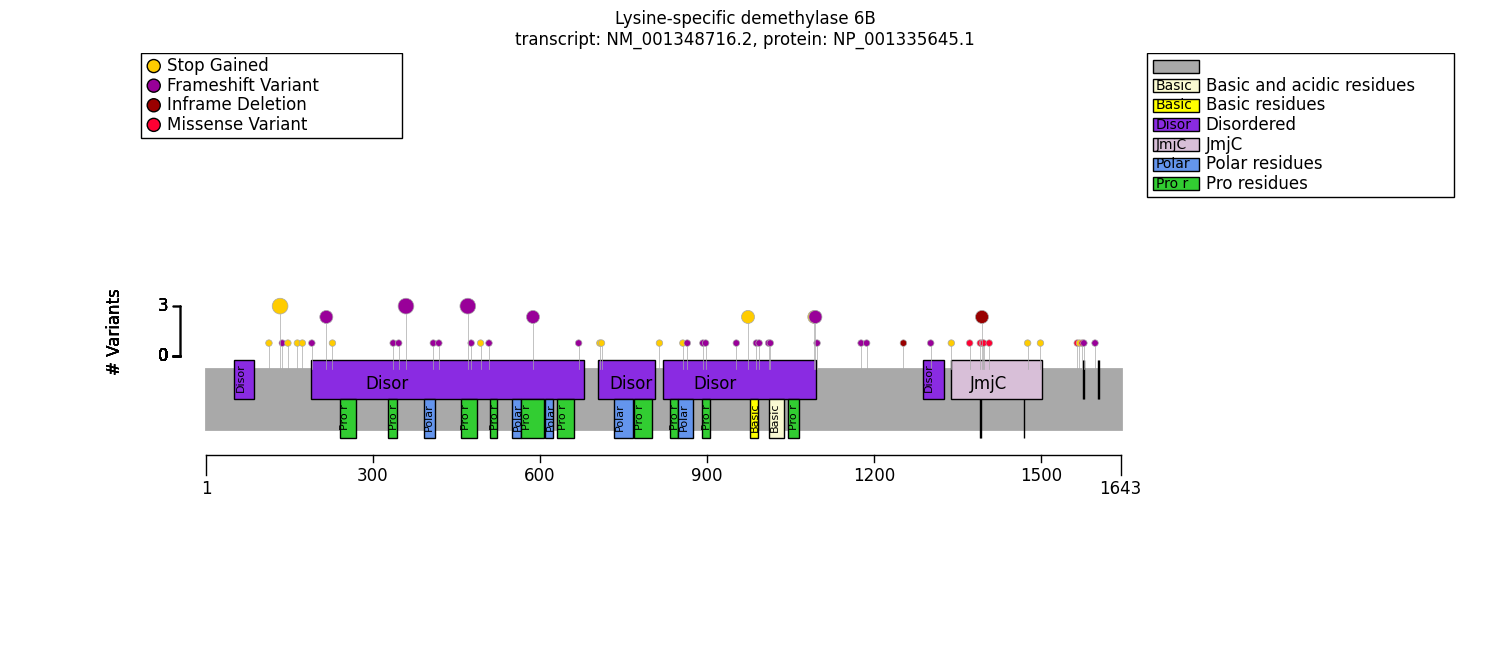

In [9]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
kdm6b_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
kdm6b_fig.tight_layout()

plt.show()

In [12]:
from gpsea.view import CohortVariantViewer
viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort=cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
3,17_7846244_7846244_C_T,c.403C>T (p.Arg135Ter),7,stop gained
3,17_7847275_7847279_TAGAG_T,c.1085_1088del (p.Glu362AlafsTer124),11,frameshift
3,17_7847703_7847705_CCT_C,c.1416_1417del (p.Cys473SerfsTer36),12,frameshift
2,17_7848054_7848055_GC_G,c.1769del (p.Pro590GlnfsTer13),12,frameshift
2,17_7849573_7849577_TAGTG_T,c.3288_3291del (p.Ser1096ArgfsTer7),12,frameshift
2,17_7849569_7849569_C_A,c.3281C>A (p.Ser1094Ter),12,stop gained
2,17_7849211_7849211_C_T,c.2923C>T (p.Arg975Ter),12,stop gained
2,17_7851969_7851972_ACTT_A,c.4187_4189del (p.Phe1396del),19,inframe deletion
2,17_7846682_7846684_CAG_C,c.654_655del (p.Glu220GlyfsTer16),9,frameshift
1,17_7848298_7848300_CTT_C,c.2012_2013del (p.Phe671Ter),12,frameshift


In [13]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_meta, mane_tx_id)
viewer.process(cohort)

Count,Name,Type,Coordinates,Variants
0,Disordered,Region,53 - 88,
20,Disordered,Region,191 - 680,p.Gly412SerfsTer77; p.Arg495Ter; p.Pro481ThrfsTer29; p.Phe671Ter; p.Pro590GlnfsTer13; p.Glu362AlafsTer124; p.Gly193GlufsTer5; p.Glu220GlyfsTer16; p.Arg340AlafsTer147; p.Cys473SerfsTer36; p.Gly421LeufsTer85; p.Arg229Ter; p.Arg513ProfsTer42; p.Ala352ProfsTer134
0,Pro residues,Compositional bias,242 - 270,
1,Pro residues,Compositional bias,329 - 344,p.Arg340AlafsTer147
1,Polar residues,Compositional bias,393 - 412,p.Gly412SerfsTer77
4,Pro residues,Compositional bias,459 - 487,p.Cys473SerfsTer36; p.Pro481ThrfsTer29
1,Pro residues,Compositional bias,511 - 524,p.Arg513ProfsTer42
0,Polar residues,Compositional bias,552 - 566,
2,Pro residues,Compositional bias,568 - 608,p.Pro590GlnfsTer13
0,Polar residues,Compositional bias,611 - 624,


# Genotype-Phenotype Correlation (GPC) Analysis
Lets investigate the JmjC domain versus the rest of the cohort. This region seems to start at 7851650 and end at 7852530, so we will filter the genomic coordinates based on that.

In [14]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [18]:
from gpsea.model import VariantEffect
from gpsea.model.genome import Region
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.analysis.predicate import protein_feature
from gpsea.view import MtcStatsViewer

jmj = protein_feature(feature_id="JmjC", protein_metadata=protein_meta)

jmj_clf = monoallelic_classifier(
    a_predicate=jmj,
    b_predicate=~jmj,
    a_label='JmjC domain',
    b_label='Other'
)

jmj_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=jmj_clf,
    pheno_clfs=pheno_clfs,
)

mtc_viewer = MtcStatsViewer()
mtc_viewer.process(jmj_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,50
HMF03,Skipping term because of a child term with the same individual counts,2
HMF07,Skipping non phenotype term,3
HMF08,Skipping general term,99
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,483


In [19]:
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo, jmj_result)

Allele group                                       JmjC domain          Other  \
                                                         Count Percent  Count   
Intellectual disability [HP:0001249]                     20/27     74%   9/23   
Feeding difficulties [HP:0011968]                         9/29     31%  13/22   
Autistic behavior [HP:0000729]                           17/33     52%  22/31   
Intellectual disability, mild [HP:0001256]                7/14     50%   6/20   
Sleep abnormality [HP:0002360]                            9/32     28%   9/22   
Joint hypermobility [HP:0001382]                         11/30     37%  11/22   
Motor delay [HP:0001270]                                 30/35     86%  27/29   
Hypotonia [HP:0001252]                                   17/34     50%  15/26   
Delayed speech and language development [HP:000...       34/36     94%  27/30   
Neurodevelopmental abnormality [HP:0012759]              37/37    100%  29/29   
Neurodevelopmental delay [HP:0012758]                    35/35    100%  29/29   
Language impairment [HP:0002463]                         34/34    100%  27/27   
Abnormal communication [HP:0034434]                      34/34    100%  27/27   
Abnormal speech pattern [HP:0002167]                     34/34    100%  27/27   
Abnormal muscle tone [HP:0003808]                        18/18    100%  15/15   
Diagnostic behavioral phenotype [HP:0025783]             17/17    100%  22/22   
Atypical behavior [HP:0000708]                           25/25    100%  28/28   
Abnormal axial skeleton morphology [HP:0009121]          17/17    100%  16/16   
Recurrent maladaptive behavior [HP:5200241]              14/14    100%  16/16   

Allele group                                                                   \
                                                   Percent Corrected p values   
Intellectual disability [HP:0001249]                   39%           0.399258   
Feeding difficulties [HP:0011968]                      59%           0.505932   
Autistic behavior [HP:0000729]                         71%           0.829086   
Intellectual disability, mild [HP:0001256]             30%           1.000000   
Sleep abnormality [HP:0002360]                         41%           1.000000   
Joint hypermobility [HP:0001382]                       50%           1.000000   
Motor delay [HP:0001270]                               93%           1.000000   
Hypotonia [HP:0001252]                                 58%           1.000000   
Delayed speech and language development [HP:000...     90%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   
Language impairment [HP:0002463]                      100%           1.000000   
Abnormal communication [HP:0034434]                   100%           1.000000   
Abnormal speech pattern [HP:0002167]                  100%           1.000000   
Abnormal muscle tone [HP:0003808]                     100%           1.000000   
Diagnostic behavioral phenotype [HP:0025783]          100%           1.000000   
Atypical behavior [HP:0000708]                        100%           1.000000   
Abnormal axial skeleton morphology [HP:0009121]       100%           1.000000   
Recurrent maladaptive behavior [HP:5200241]           100%           1.000000   

Allele group                                                  
                                                    p values  
Intellectual disability [HP:0001249]                0.021014  
Feeding difficulties [HP:0011968]                   0.053256  
Autistic behavior [HP:0000729]                      0.130908  
Intellectual disability, mild [HP:0001256]          0.296203  
Sleep abnormality [HP:0002360]                      0.386333  
Joint hypermobility [HP:0001382]                    0.401172  
Motor delay [HP:0001270]                            0.441783  
Hypotonia [HP:0001252]       

In [20]:
# Compare N and C terminal regions
from gpsea.analysis.predicate import protein_region

middle_residue = 1643 // 2
nterm = protein_region(region=Region(1, middle_residue), tx_id=mane_tx_id)
nterm_clf = monoallelic_classifier(
    a_predicate=nterm,
    b_predicate=~ nterm,
    a_label="N term",
    b_label="C term"
)

nterm_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=nterm_clf,
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo, nterm_result)

Allele group                                       N term         C term  \
                                                    Count Percent  Count   
Joint hypermobility [HP:0001382]                    13/23     57%   9/29   
Motor delay [HP:0001270]                            23/28     82%  34/36   
Hypotonia [HP:0001252]                              11/25     44%  21/35   
Intellectual disability, mild [HP:0001256]           7/14     50%   6/20   
Sleep abnormality [HP:0002360]                       9/22     41%   9/32   
Intellectual disability [HP:0001249]                13/20     65%  16/30   
Autistic behavior [HP:0000729]                      19/29     66%  20/35   
Neurodevelopmental abnormality [HP:0012759]         29/29    100%  37/37   
Delayed speech and language development [HP:000...  26/28     93%  35/38   
Neurodevelopmental delay [HP:0012758]               27/27    100%  37/37   
Language impairment [HP:0002463]                    26/26    100%  35/35   
Abnormal communication [HP:0034434]                 26/26    100%  35/35   
Abnormal speech pattern [HP:0002167]                26/26    100%  35/35   
Abnormal muscle tone [HP:0003808]                   12/12    100%  21/21   
Diagnostic behavioral phenotype [HP:0025783]        19/19    100%  20/20   
Atypical behavior [HP:0000708]                      24/24    100%  29/29   
Abnormal axial skeleton morphology [HP:0009121]     14/14    100%  19/19   
Recurrent maladaptive behavior [HP:5200241]         11/11    100%  19/19   
Feeding difficulties [HP:0011968]                    9/22     41%  13/29   

Allele group                                                                   \
                                                   Percent Corrected p values   
Joint hypermobility [HP:0001382]                       31%                1.0   
Motor delay [HP:0001270]                               94%                1.0   
Hypotonia [HP:0001252]                                 60%                1.0   
Intellectual disability, mild [HP:0001256]             30%                1.0   
Sleep abnormality [HP:0002360]                         28%                1.0   
Intellectual disability [HP:0001249]                   53%                1.0   
Autistic behavior [HP:0000729]                         57%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Delayed speech and language development [HP:000...     92%                1.0   
Neurodevelopmental delay [HP:0012758]                 100%                1.0   
Language impairment [HP:0002463]                      100%                1.0   
Abnormal communication [HP:0034434]                   100%                1.0   
Abnormal speech pattern [HP:0002167]                  100%                1.0   
Abnormal muscle tone [HP:0003808]                     100%                1.0   
Diagnostic behavioral phenotype [HP:0025783]          100%                1.0   
Atypical behavior [HP:0000708]                        100%                1.0   
Abnormal axial skeleton morphology [HP:0009121]       100%                1.0   
Recurrent maladaptive behavior [HP:5200241]           100%                1.0   
Feeding difficulties [HP:0011968]                      45%                1.0   

Allele group                                                  
                                                    p values  
Joint hypermobility [HP:0001382]                    0.091675  
Motor delay [HP:0001270]                            0.224638  
Hypotonia [HP:0001252]                              0.295593  
Intellectual disability, mild [HP:0001256]          0.296203  
Sleep abnormality [HP:0002360]                      0.386333  
Intellectual disability [HP:0001249]                0.560156  
Autistic behavior [HP:0000729]                      0.608815  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Delayed speech and language development [HP:000...  1.000000  
Neurodev

# Summary

In [21]:
caption = "Stolerman et al (2016) identified no significant genotype-phenotype correlations \\cite{PMID_31124279}"

from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport

f_results =  (
 GPAnalysisResultSummary.from_multi(
        result=jmj_result,
    ), GPAnalysisResultSummary.from_multi(
        result=nterm_result,
    ),
)

report = GpseaAnalysisReport(
    name=gene_symbol,
    cohort=cohort,
    fet_results=f_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
    caption=caption,
)

In [22]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
JmjC domain,Other,19,0
Genotype (A),Genotype (B),Tests performed,Significant tests
N term,C term,19,0


In [23]:
summarizer.process_latex(report=report, protein_fig=kdm6b_fig)

Figure saved to ../../supplement/img/KDM6B_protein_diagram-draft.pdf
Output to ../../supplement/tex/KDM6B_summary_draft.tex
